<a href="https://colab.research.google.com/github/marcelogarret/rna/blob/main/aula10a_forecasting_garret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-05-06 22:28:10--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-05-06 22:28:10 (45.0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



**Dataset Passageiros de Companhias Aéreas**

Registra o número mensal em milhares de passageiros de companhias aéreas dos EUA de 1949 a 1960. É uma série temporal clássica que é geralmente usada para testar métodos de previsão de séries temporais

**Parâmetros do Dataset**

1.   **sequence_length**:  são utilizados 12 meses (1 ano) de dados para prever o número de passageiros no próximo mês. Isso permite capturar a sazonalidade anual, uma característica importante deste dataset.
2.   **sampling_rate**: Cada registro mensal será considerado, sem pular meses, para preservar a continuidade sazonal.
3.   **delay**: A previsão será feita para o mês subsequente, adequada para planejamento e alocação de recursos.

In [2]:
import numpy as np

raw_data = []
with open("airline-passengers.csv") as f:
    f.readline()  # Pula o cabeçalho
    for line in f:
        fields = line.split(',')
        raw_data.append(float(fields[1]))  # Assume que a segunda coluna é o número de passageiros

raw_data = np.array(raw_data)
print("Número total de pontos:", len(raw_data))

Número total de pontos: 144


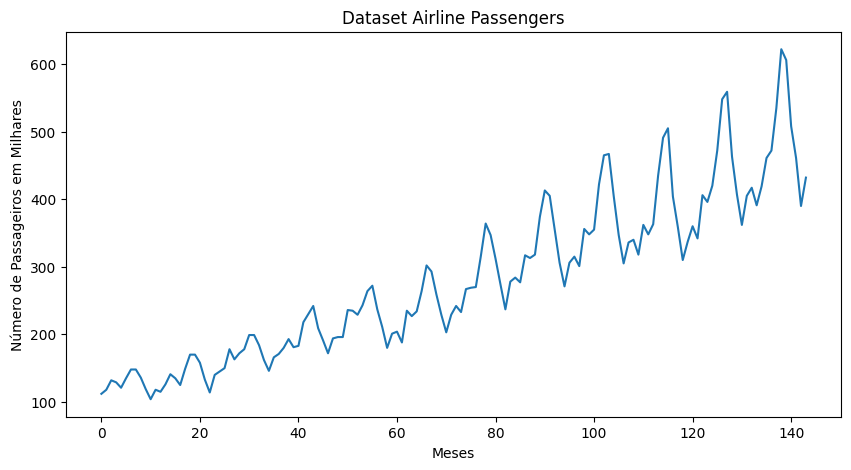

In [3]:
from matplotlib import pyplot as plt

# Gráfico para visualizar dados
plt.figure(figsize=(10, 5))
plt.plot(range(len(raw_data)), raw_data)
plt.title("Dataset Airline Passengers")
plt.xlabel("Meses")
plt.ylabel("Número de Passageiros em Milhares")
plt.show()

In [4]:
num_train_samples = int(0.75 * len(raw_data))
num_val_samples = int(0.125 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(108, 18, 18)

In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
train_data = raw_data[:num_train_samples]
val_data = raw_data[num_train_samples:num_train_samples + num_val_samples]
test_data = raw_data[num_train_samples + num_val_samples:]

In [7]:
from tensorflow import keras

# Parâmetros para a criação do dataset
sequence_length = 12  # 12 meses para previsão
sampling_rate = 1     # Cada mês é considerado
delay = 1             # Previsão para o próximo mês

train_dataset = keras.utils.timeseries_dataset_from_array(
    train_data[:-delay],
    targets=train_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=32,
    shuffle=True
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    val_data[:-delay],
    targets=val_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=32,
    shuffle=True
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    test_data[:-delay],
    targets=test_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=32,
    shuffle=True
)

In [8]:
for samples, targets in train_dataset:
  print("samples shape", samples.shape)
  print("targets shape", targets.shape)
  break

samples shape (32, 12)
targets shape (32,)


#baseline

In [9]:
# Avaliação ingênua (Naive)
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1] # A última observação é usada como previsão
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 0.35
Test MAE: 1.20


#densely conected

In [10]:
from tensorflow.keras import layers

# Dado que estamos tratando de uma série univariada, `raw_data.shape[-1]` é 1
# Configurando o modelo de rede neural
inputs = keras.Input(shape=(sequence_length, 1))  # Modificado para refletir a única série de entrada
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Callback para salvar o modelo com o melhor desempenho baseado no conjunto de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_dense.keras",
                                    save_best_only=True)
]

# Compilação do modelo com otimizador RMSprop, função de perda MSE e acompanhamento do MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_dense.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 105ms/step - loss: 0.9354 - mae: 0.7945 - val_loss: 1.1282 - val_mae: 0.8732
Epoch 2/10
3/3 [==============================] - 0s 29ms/step - loss: 0.4984 - mae: 0.5798 - val_loss: 0.6024 - val_mae: 0.6080
Epoch 3/10
3/3 [==============================] - 0s 31ms/step - loss: 0.3199 - mae: 0.4729 - val_loss: 0.4256 - val_mae: 0.5382
Epoch 4/10
3/3 [==============================] - 0s 29ms/step - loss: 0.2214 - mae: 0.3992 - val_loss: 0.3715 - val_mae: 0.5048
Epoch 5/10
3/3 [==============================] - 0s 31ms/step - loss: 0.1582 - mae: 0.3376 - val_loss: 0.3284 - val_mae: 0.4696
Epoch 6/10
3/3 [==============================] - 0s 30ms/step - loss: 0.1190 - mae: 0.2879 - val_loss: 0.3108 - val_mae: 0.4600
Epoch 7/10
3/3 [==============================] - 0s 28ms/step - loss: 0.0948 - mae: 0.2479 - val_loss: 0.2933 - val_mae: 0.4506
Epoch 8/10
3/3 [==============================] - 0s 38ms/step - loss: 0.0806 - mae: 0.2177 - va

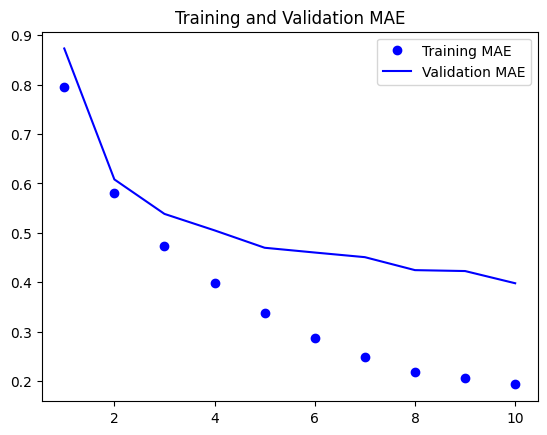

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

#1D convolutional model

In [12]:
# Ajustando o modelo para evitar a redução excessiva de dimensionalidade
inputs = keras.Input(shape=(sequence_length, 1))  # A entrada ainda espera uma única série temporal por amostra
x = layers.Conv1D(16, 24, activation="relu", padding='same')(inputs)  # Aplicando um Conv1D com 8 filtros de tamanho 24
x = layers.MaxPooling1D(2)(x)  # Aplicando apenas um pooling para reduzir a dimensionalidade
x = layers.Conv1D(16, 8, activation="relu", padding='same')(x)  # Aplicando outro Conv1D com 8 filtros de tamanho 12
x = layers.MaxPooling1D(2)(x) # Aplicando apenas um pooling para reduzir a dimensionalidade
x = layers.Conv1D(16, 3, activation="relu", padding='same')(x)  # Mantendo as dimensões com padding 'same'
x = layers.GlobalAveragePooling1D()(x)  # Global average pooling para resumir as características
outputs = layers.Dense(1)(x)  # Camada de saída
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo baseado no desempenho de validação
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_conv_adjusted.keras",
                                    save_best_only=True)
]

# Compilação do modelo
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_conv_adjusted.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 164ms/step - loss: 0.6768 - mae: 0.6859 - val_loss: 2.2627 - val_mae: 1.3408
Epoch 2/10
3/3 [==============================] - 0s 39ms/step - loss: 0.5472 - mae: 0.6158 - val_loss: 1.5443 - val_mae: 1.0498
Epoch 3/10
3/3 [==============================] - 0s 36ms/step - loss: 0.4464 - mae: 0.5531 - val_loss: 1.0805 - val_mae: 0.8101
Epoch 4/10
3/3 [==============================] - 0s 36ms/step - loss: 0.3627 - mae: 0.4949 - val_loss: 0.7832 - val_mae: 0.6640
Epoch 5/10
3/3 [==============================] - 0s 36ms/step - loss: 0.2932 - mae: 0.4513 - val_loss: 0.6662 - val_mae: 0.6015
Epoch 6/10
3/3 [==============================] - 0s 34ms/step - loss: 0.2333 - mae: 0.4074 - val_loss: 0.6267 - val_mae: 0.5796
Epoch 7/10
3/3 [==============================] - 0s 35ms/step - loss: 0.1699 - mae: 0.3400 - val_loss: 0.4979 - val_mae: 0.4922
Epoch 8/10
3/3 [==============================] - 0s 35ms/step - loss: 0.1286 - mae: 0.2920 - va

#Rede Recorrente


In [13]:
# Definindo o modelo LSTM para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(64)(inputs)  # Usando uma camada LSTM com 32 unidades
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm.keras",  # Nome alterado para refletir o novo dataset
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e o métrico MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 342ms/step - loss: 0.4181 - mae: 0.5444 - val_loss: 1.3604 - val_mae: 0.9508
Epoch 2/10
3/3 [==============================] - 0s 61ms/step - loss: 0.1796 - mae: 0.3285 - val_loss: 0.8406 - val_mae: 0.6786
Epoch 3/10
3/3 [==============================] - 0s 48ms/step - loss: 0.1385 - mae: 0.2879 - val_loss: 0.7493 - val_mae: 0.6263
Epoch 4/10
3/3 [==============================] - 0s 59ms/step - loss: 0.1361 - mae: 0.2907 - val_loss: 0.7344 - val_mae: 0.6171
Epoch 5/10
3/3 [==============================] - 0s 66ms/step - loss: 0.1364 - mae: 0.2831 - val_loss: 0.6392 - val_mae: 0.5532
Epoch 6/10
3/3 [==============================] - 0s 44ms/step - loss: 0.1280 - mae: 0.2831 - val_loss: 0.7979 - val_mae: 0.6541
Epoch 7/10
3/3 [==============================] - 0s 44ms/step - loss: 0.1228 - mae: 0.2734 - val_loss: 0.7559 - val_mae: 0.6304
Epoch 8/10
3/3 [==============================] - 0s 63ms/step - loss: 0.1181 - mae: 0.2660 - va

# dropout-regularized LSTM

In [14]:
# Definindo o modelo LSTM com dropout para prevenção de overfitting
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.LSTM(64)(inputs)  # Usando LSTM com 64 unidades, sem dropout recorrente
x = layers.Dropout(0.25)(x)  # Dropout após a camada LSTM para reduzir ainda mais o overfitting
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_dropout.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_dropout.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
3/3 [==============================] - 3s 234ms/step - loss: 0.7159 - mae: 0.7051 - val_loss: 2.7746 - val_mae: 1.5058
Epoch 2/10
3/3 [==============================] - 0s 36ms/step - loss: 0.4024 - mae: 0.5196 - val_loss: 1.8780 - val_mae: 1.1708
Epoch 3/10
3/3 [==============================] - 0s 34ms/step - loss: 0.2268 - mae: 0.3644 - val_loss: 1.2810 - val_mae: 0.8833
Epoch 4/10
3/3 [==============================] - 0s 33ms/step - loss: 0.1451 - mae: 0.2939 - val_loss: 0.9085 - val_mae: 0.6995
Epoch 5/10
3/3 [==============================] - 0s 34ms/step - loss: 0.1494 - mae: 0.2946 - val_loss: 0.8747 - val_mae: 0.6820
Epoch 6/10
3/3 [==============================] - 0s 36ms/step - loss: 0.1547 - mae: 0.3036 - val_loss: 0.7688 - val_mae: 0.6225
Epoch 7/10
3/3 [==============================] - 0s 22ms/step - loss: 0.1383 - mae: 0.2978 - val_loss: 0.7857 - val_mae: 0.6335
Epoch 8/10
3/3 [==============================] - 0s 37ms/step - loss: 0.1501 - mae: 0.2842 - va

#bidirectional LSTM

In [15]:
# Definindo o modelo LSTM Bidirecional para a previsão de séries temporais
inputs = keras.Input(shape=(sequence_length, 1))  # Ajuste para 1 feature no dataset 'airline-passengers'
x = layers.Bidirectional(layers.LSTM(64))(inputs)  # LSTM bidirecional com 64 unidades em cada direção
outputs = layers.Dense(1)(x)  # Camada de saída para prever o número de passageiros
model = keras.Model(inputs, outputs)

# Callback para salvar o melhor modelo durante o treinamento
callbacks = [
    keras.callbacks.ModelCheckpoint("airline_lstm_bidirectional.keras",  # Nome do arquivo de modelo atualizado
                                    save_best_only=True)
]

# Compilando o modelo com a função de perda MSE e a métrica MAE
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Treinando o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# Carregando o melhor modelo salvo durante o treinamento
model = keras.models.load_model("airline_lstm_bidirectional.keras")

# Avaliando o modelo no conjunto de teste e imprimindo o MAE de teste
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
3/3 [==============================] - 4s 745ms/step - loss: 0.5204 - mae: 0.5914 - val_loss: 1.5704 - val_mae: 1.0547
Epoch 2/10
3/3 [==============================] - 0s 75ms/step - loss: 0.2137 - mae: 0.3709 - val_loss: 0.9033 - val_mae: 0.7029
Epoch 3/10
3/3 [==============================] - 0s 63ms/step - loss: 0.1347 - mae: 0.2798 - val_loss: 0.6599 - val_mae: 0.5592
Epoch 4/10
3/3 [==============================] - 0s 40ms/step - loss: 0.1182 - mae: 0.2669 - val_loss: 0.5993 - val_mae: 0.5347
Epoch 5/10
3/3 [==============================] - 0s 23ms/step - loss: 0.1161 - mae: 0.2703 - val_loss: 0.6961 - val_mae: 0.5885
Epoch 6/10
3/3 [==============================] - 0s 22ms/step - loss: 0.1132 - mae: 0.2564 - val_loss: 0.6090 - val_mae: 0.5372
Epoch 7/10
3/3 [==============================] - 0s 25ms/step - loss: 0.1071 - mae: 0.2533 - val_loss: 0.6105 - val_mae: 0.5367
Epoch 8/10
3/3 [==============================] - 0s 21ms/step - loss: 0.1060 - mae: 0.2583 - va